In [33]:
!pip install pgmpy
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
import pylab

In [35]:
# train a Naive Bayes classifier on the training set
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.feature_selection import SelectKBest, chi2

In [36]:
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
#pe = ParameterEstimator(best_model, data)
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
# Infering the posterior probability
from pgmpy.inference import VariableElimination
from pandas.core.groupby.groupby import DataFrame

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [38]:
# upload data from local disk
import io

from google.colab import files
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['lymphography_data.csv']))
df_copy = df.copy()

Saving lymphography_data.csv to lymphography_data (2).csv


In [81]:
# restore from the copy for a rerun
df = df_copy

# show first 5 rows
df.head()

,Class,Lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
0,3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
1,2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
2,3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
4,2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


In [82]:
# look at the data types and null values in the columns
# there are no null values in the data , and data is clean, no need for any preprocessing to clean the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Class             148 non-null    int64
 1   Lymphatics        148 non-null    int64
 2   block of affere   148 non-null    int64
 3   bl. of lymph. c   148 non-null    int64
 4   bl. of lymph. s   148 non-null    int64
 5   by pass           148 non-null    int64
 6   extravasates      148 non-null    int64
 7   regeneration of   148 non-null    int64
 8   early uptake in   148 non-null    int64
 9   lym.nodes dimin   148 non-null    int64
 10  lym.nodes enlar   148 non-null    int64
 11  changes in lym    148 non-null    int64
 12   defect in node   148 non-null    int64
 13   changes in node  148 non-null    int64
 14  changes in stru   148 non-null    int64
 15  special forms     148 non-null    int64
 16  dislocation of    148 non-null    int64
 17  exclusion of no   148 non-null    i

In [83]:
# another way to know the null values in the dataset
df.isnull().sum()

Class               0
Lymphatics          0
block of affere     0
bl. of lymph. c     0
bl. of lymph. s     0
by pass             0
extravasates        0
regeneration of     0
early uptake in     0
lym.nodes dimin     0
lym.nodes enlar     0
changes in lym      0
 defect in node     0
 changes in node    0
changes in stru     0
special forms       0
dislocation of      0
exclusion of no     0
no. of nodes in     0
dtype: int64

In [84]:
# Get the distribution of observations per Class in the dataset
df['Class'].value_counts()

2    81
3    61
4     4
1     2
Name: Class, dtype: int64

In [85]:
# Here we can ignore observations in Class 4 and 1, as these are very few to make any predictions from the dataset
df = df[(df.Class != 1) & (df.Class != 4)]
df['Class'].value_counts()

2    81
3    61
Name: Class, dtype: int64

In [86]:
# feature selection function, used later in the code
def select_features(X_train, y_train, X_test, k='all'):
    # Create and fit selector
    selector = SelectKBest(score_func=chi2, k=k).fit(X_train, y_train)

    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    X_train_features = X_train.iloc[:,cols]
    X_test_features = X_test.iloc[:,cols]
    return X_train_features, X_test_features, selector

In [87]:
# load the X and y variablesfrom the dataset
X = df.drop(['Class'], axis=1)

y = df['Class']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

Feature 0: 0.243594
Feature 1: 3.712813
Feature 2: 0.514706
Feature 3: 0.023558
Feature 4: 0.514286
Feature 5: 0.021192
Feature 6: 0.123077
Feature 7: 1.723547
Feature 8: 0.012500
Feature 9: 3.640945
Feature 10: 0.250000
Feature 11: 0.060368
Feature 12: 0.618557
Feature 13: 7.555566
Feature 14: 2.716809
Feature 15: 0.515644
Feature 16: 0.344101
Feature 17: 37.494358


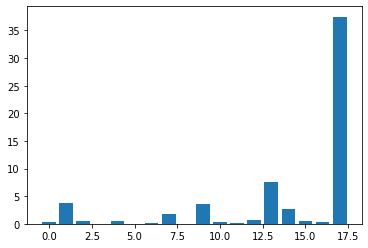

In [88]:
# feature selection, from the X variables only
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# print the scores 
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [92]:
# feature selection, with k=9 features
X_train_fs, X_test_fs, _ = select_features(X_train, y_train, X_test, k=8)

# check the size of the datasets 
print(f'size of X_train:{X_train_fs.shape}\nsize of X_test :{X_test_fs.shape}\nsize of y_train:{y_train.shape}\nsize of y_test :{y_test.shape}')

# combining the dataframe 
data = X_train_fs.join(y_train)

size of X_train:(99, 8)
size of X_test :(43, 8)
size of y_train:(99,)
size of y_test :(43,)


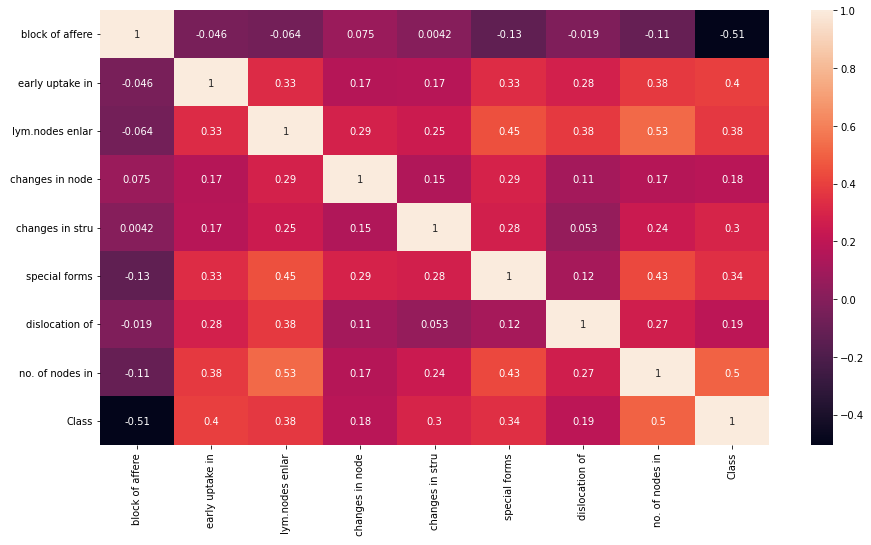

In [93]:
plt.figure(figsize = (15,8))
sns.heatmap(data.corr(),annot=True)

In [97]:
model =keras.Sequential([
  keras.layers.Dense(18, input_dim=X_train_fs.shape[1], activation= "relu"),
  keras.layers.Dense(5, activation= "relu"),
  keras.layers.Dense(1, activation="sigmoid")])

In [98]:
model.compile(optimizer='adam',loss='CategoricalCrossentropy', metrics=['accuracy'])
hist=model.fit(X_train_fs,y_train,epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 10/100
4/4 [==============================] - 0s 

In [99]:
model.evaluate(X_test_fs,y_test)

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [22]:
import warnings
warnings.filterwarnings('ignore') 

In [100]:
y_pred = model.predict(X_test_fs)
print(classification_report(y_test,y_pred))

2/2 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00      26.0
         3.0       0.00      0.00      0.00      17.0

    accuracy                           0.00      43.0
   macro avg       0.00      0.00      0.00      43.0
weighted avg       0.00      0.00      0.00      43.0



In [101]:
y_pred = model.predict(X_train_fs)
print(classification_report(y_train, y_pred))

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00      55.0
         3.0       0.00      0.00      0.00      44.0

    accuracy                           0.00      99.0
   macro avg       0.00      0.00      0.00      99.0
weighted avg       0.00      0.00      0.00      99.0

